In [ ]:
import os
from google.colab import drive
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/DATASET/

/content/drive/MyDrive/DATASET


In [ ]:
%cd makanan_kudapan/

/content/makanan_kudapan


In [ ]:
# prompt: command untuk memindahkan file di google colab dari satu folder ke folder lain

!cp /content/drive/MyDrive/DATASET/Archive.zip /content/makanan_kudapan/Archive.zip


In [ ]:
!unzip Archive.zip

In [ ]:
BASE_DIR = '/content/makanan_kudapan'

In [ ]:
train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'validation')
test_dir = os.path.join(BASE_DIR, 'test')

In [ ]:
os.listdir(train_dir)

['kue_serabi',
 'kue_lumpur',
 'kue_putri_salju',
 'kue_risoles',
 'kue_lapis',
 '.DS_Store',
 'kue_kastengel',
 'kue_dadar_gulung',
 'kue_klepon']

In [ ]:
if os.path.exists(os.path.join(train_dir, ".DS_Store")):
  os.remove(os.path.join(train_dir, ".DS_Store"))


Images for label: kue_serabi


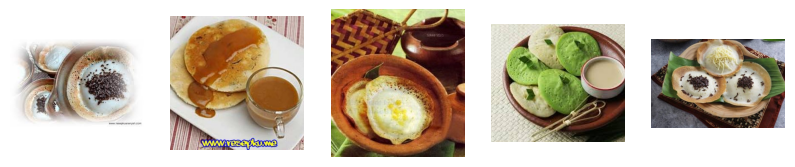



Images for label: kue_lumpur


UnidentifiedImageError: cannot identify image file '/content/makanan_kudapan/train/kue_lumpur/.DS_Store'

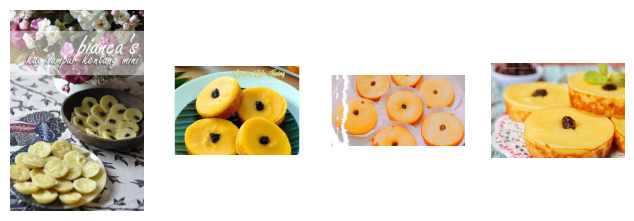

In [ ]:
# prompt: buatkan kode untuk menampilkan gambar di setiap label

import matplotlib.pyplot as plt

def plot_images(directory, num_images=5):
  """
  This function displays a given number of images from a directory.

  Args:
    directory: The directory containing the images.
    num_images: The number of images to display.
  """
  plt.figure(figsize=(10, 10))
  for i in range(num_images):
    # Choose a random image from the directory.
    image_path = os.path.join(directory, random.choice(os.listdir(directory)))
    # Read the image and display it.
    img = plt.imread(image_path)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis('off')

  plt.show()

# Display images from each label
for label in os.listdir(train_dir):
  label_dir = os.path.join(train_dir, label)
  print(f"Images for label: {label}")
  plot_images(label_dir)
  print("\n")


In [ ]:
# Image Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

In [ ]:
# train generator

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3275 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


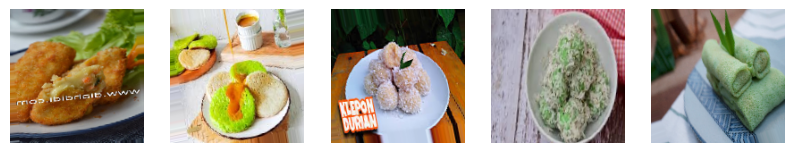

In [ ]:
images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(5):
  plt.subplot(1, 5, i + 1)
  plt.imshow(images[i])
  plt.axis('off')

plt.show()

In [ ]:
# build model

def build_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(8, activation='softmax')
  ])

  # mungkin coba tambahin arsitektur layernya dah

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',
      metrics=['accuracy'])

  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [ ]:
# create callback class

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    print(logs)
    if logs.get('accuracy') > 0.99:
      print("\nAkurasi telah mencapai 99%!")
      self.model.stop_training = True

In [ ]:
my_callback = myCallback()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=60, # banyakin epoch coba
    validation_data=val_generator,
    validation_steps=5,
    verbose=2,
    callbacks=[my_callback]
)

Epoch 1/60
{'loss': 1.9819875955581665, 'accuracy': 0.20499999821186066, 'val_loss': 1.653908133506775, 'val_accuracy': 0.3125}
25/25 - 63s - loss: 1.9820 - accuracy: 0.2050 - val_loss: 1.6539 - val_accuracy: 0.3125 - 63s/epoch - 3s/step
Epoch 2/60
{'loss': 1.6067737340927124, 'accuracy': 0.32862645387649536, 'val_loss': 1.586949110031128, 'val_accuracy': 0.32499998807907104}
25/25 - 57s - loss: 1.6068 - accuracy: 0.3286 - val_loss: 1.5869 - val_accuracy: 0.3250 - 57s/epoch - 2s/step
Epoch 3/60
{'loss': 1.4471625089645386, 'accuracy': 0.40179717540740967, 'val_loss': 1.6025161743164062, 'val_accuracy': 0.34375}
25/25 - 54s - loss: 1.4472 - accuracy: 0.4018 - val_loss: 1.6025 - val_accuracy: 0.3438 - 54s/epoch - 2s/step
Epoch 4/60
{'loss': 1.4789313077926636, 'accuracy': 0.4415917694568634, 'val_loss': 1.4089471101760864, 'val_accuracy': 0.4312500059604645}
25/25 - 54s - loss: 1.4789 - accuracy: 0.4416 - val_loss: 1.4089 - val_accuracy: 0.4313 - 54s/epoch - 2s/step
Epoch 5/60
{'loss': 1

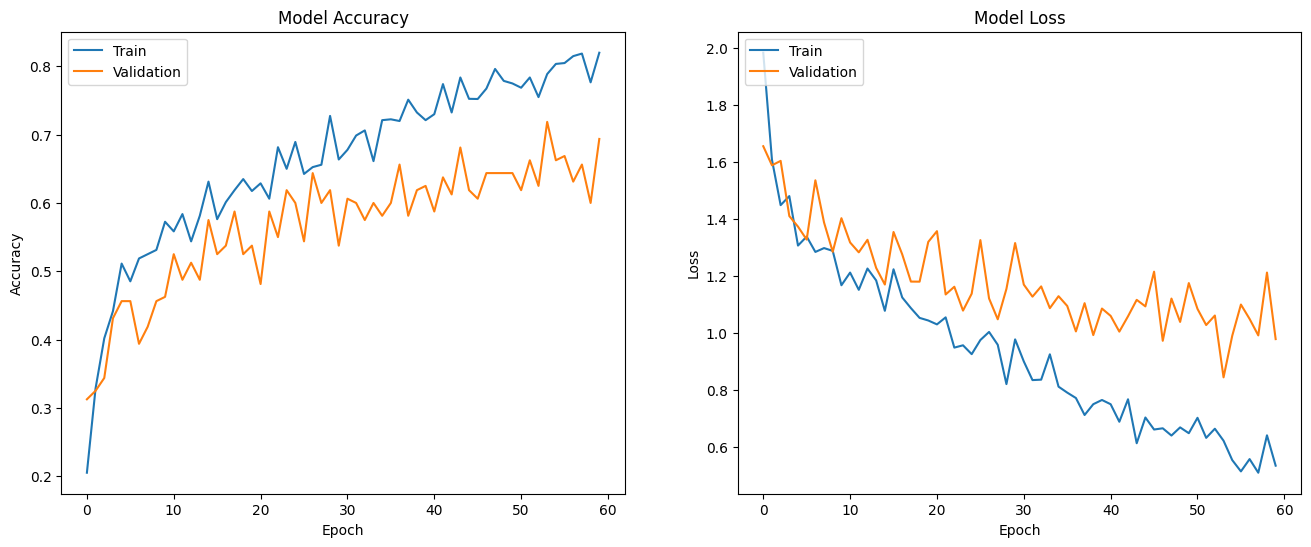

In [ ]:
# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# Display the plots
plt.show()


5/5 [==============================] - 5s 915ms/step


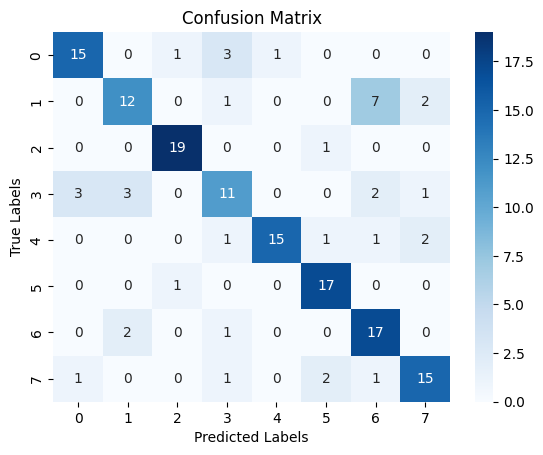

In [ ]:
# Get predictions from the model
predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the test generator
true_labels = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
class_names = [
    'dadar gulung',
    'kastengel',
    'klepon',
    'lapis',
    'lumpur',
    'putri salju',
    'risoles',
    'serabi'
]

Saving WhatsApp Image 2024-06-14 at 16.39.01 (1).jpeg to WhatsApp Image 2024-06-14 at 16.39.01 (1).jpeg
1/1 [==============================] - 0s 79ms/step
clasess - [[0. 0. 1. 0. 0. 0. 0. 0.]]
2
class name - klepon


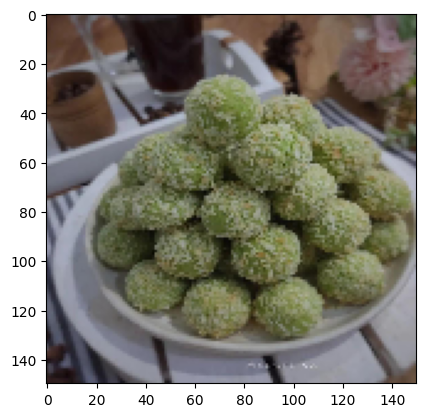

In [ ]:
upload_files = files.upload()
for filename in upload_files.keys():
  path = filename
  img = tf.keras.preprocessing.image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = tf.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(f"clasess - {classes}")
  print(np.argmax(classes))
  print(f"class name - {class_names[np.argmax(classes)]}")
  plt.show()
  print('\n')

In [ ]:
model.save_weights('my_model.h5')

In [ ]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# prompt: simpan model yang telah dibuat

model.save('my_model.h5')
